In [8]:
import os
from os.path import join

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('../paper.mcstyle')

import seaborn as sns
import pandas as pd

import numpy as np
from scipy.stats import norm

import torch
import sbibm
import yaml
from tqdm import tqdm

In [2]:
cfgdir = './configs'
wdir = './slcp'

## Generate configurations

In [6]:
model_names = ['NPE', 'NLE', 'NRE', 'SNPE', 'SNLE', 'SNRE', 
               'pydelfi', 'Spydelfi', 'lampe']

# create directories
for i, n in enumerate(model_names):
    os.makedirs(join(cfgdir, n), exist_ok=True)
    os.makedirs(join(wdir, n), exist_ok=True)

# # clear configs
# for i, n in enumerate(model_names+['data']):
#     os.system(f'rm {join(cfgdir, n)}/*.yaml')

In [7]:
# create normal data configs
base = dict(
    in_dir = './slcp/data',
    x_file = '1000_x.npy',
    theta_file = '1000_theta.npy',
    xobs_file = 'obs_1.npy',
    thetaobs_file = 'obstrue.npy'
)
Ns = [1_000, 10_000, 100_000]

for i, n in enumerate(Ns):
    for j in range(1,11):
        base['x_file'] = f'{n}_x.npy'
        base['theta_file'] = f'{n}_theta.npy'
        base['xobs_file'] = f'obs_{j}.npy'

        filename = join(cfgdir, 'data', f'{n}_{j}.yaml')
        with open(filename, 'w') as f:
            yaml.dump(base, f)

# create seq data configs
base['out_dir'] = './wdir/data'
base['num_simulations'] = 1000

seqNs = [n//10 for n in Ns]
for i, n in enumerate(seqNs):
    for j in range(1,11):
        base['x_file'] = f'{n}_x.npy'
        base['theta_file'] = f'{n}_theta.npy'
        base['xobs_file'] = f'obs_{j}.npy'

        filename = join(cfgdir, 'data', f'seq{n}_{j}.yaml')
        with open(filename, 'w') as f:
            yaml.dump(base, f)

print('done')

done


In [8]:
# create inference configs
def save_config(base, names, Ns):
    for m in names:
        for i in range(1,11):
            for n in Ns:
                base['model']['name'] = f'{m}_obs{i}_n{n}'
                base['output_path'] = f'./slcp/{m}'
                filename = join(cfgdir, m, f'obs{i}_n{n}_inf.yaml')
                print(filename)
                with open(filename, 'w') as f:
                    yaml.dump(base, f)


# NPE
base = dict(
    prior={
        'module': 'ili.utils',
        'class': 'Uniform',
        'args': dict(
            low=[-3]*5,
            high=[3]*5
        )
    },
    model={
        'module':'sbi.inference',
        'class':'SNPE',
        'name':'NPE0',
        'nets':[
            dict(
                model='nsf',
                hidden_features=50,
                num_transforms=5,
            )
        ]
    },
    train_args=dict(
        training_batch_size=32,
        learning_rate=1e-5,
        num_round=10,
    ),
    device='cpu',
    output_path='./slcp/NPE',
)
save_config(base, ['NPE'], Ns)
save_config(base, ['SNPE'], seqNs)

# NLE
base['model']['class'] = 'SNLE'
base['model']['nets'] = [
    dict(
        model='maf',
        hidden_features=50,
        num_transforms=5,
    )
]
save_config(base, ['NLE'], Ns)
save_config(base, ['SNLE'], seqNs)

# NRE
base['model']['class'] = 'SNRE'
base['model']['nets'] = [
    dict(
        model='resnet',
        hidden_features=50,
        num_blocks=2,
    )
]
save_config(base, ['NRE'], Ns)
save_config(base, ['SNRE'], seqNs)


./configs/NPE/obs1_n1000_inf.yaml
./configs/NPE/obs1_n10000_inf.yaml
./configs/NPE/obs1_n100000_inf.yaml
./configs/NPE/obs2_n1000_inf.yaml
./configs/NPE/obs2_n10000_inf.yaml
./configs/NPE/obs2_n100000_inf.yaml
./configs/NPE/obs3_n1000_inf.yaml
./configs/NPE/obs3_n10000_inf.yaml
./configs/NPE/obs3_n100000_inf.yaml
./configs/NPE/obs4_n1000_inf.yaml
./configs/NPE/obs4_n10000_inf.yaml
./configs/NPE/obs4_n100000_inf.yaml
./configs/NPE/obs5_n1000_inf.yaml
./configs/NPE/obs5_n10000_inf.yaml
./configs/NPE/obs5_n100000_inf.yaml
./configs/NPE/obs6_n1000_inf.yaml
./configs/NPE/obs6_n10000_inf.yaml
./configs/NPE/obs6_n100000_inf.yaml
./configs/NPE/obs7_n1000_inf.yaml
./configs/NPE/obs7_n10000_inf.yaml
./configs/NPE/obs7_n100000_inf.yaml
./configs/NPE/obs8_n1000_inf.yaml
./configs/NPE/obs8_n10000_inf.yaml
./configs/NPE/obs8_n100000_inf.yaml
./configs/NPE/obs9_n1000_inf.yaml
./configs/NPE/obs9_n10000_inf.yaml
./configs/NPE/obs9_n100000_inf.yaml
./configs/NPE/obs10_n1000_inf.yaml
./configs/NPE/obs10_

In [9]:
def save_config(base, names, Ns):
    for m in names:
        for i in range(1,11):
            for n in Ns:
                base['model']['name'] = f'{m}_obs{i}_n{n}'
                base['output_path'] = f'./slcp/{m}'
                filename = join(cfgdir, m, f'obs{i}_n{n}_inf.yaml')
                print(filename)
                with open(filename, 'w') as f:
                    yaml.dump(base, f)

# pydelfi
base = {
    'n_params': 5,
    'n_data': 8,
    'prior': {
        'module': 'ili.utils',
        'class': 'Uniform',
        'args': {
            'low': [-3]*5,
            'high': [3]*5,
        }
    },
    'model': {
        'module': 'ili.inference.pydelfi_wrappers',
        'class': 'DelfiWrapper',
        'name': 'obs0_n1000_pydelfi',
        'kwargs': {
            'nwalkers': 20
        },
        'nets': [
            {
                'module': 'pydelfi.ndes',
                'class': 'ConditionalMaskedAutoregressiveFlow',
                'args': {
                    'n_hiddens': [50]*5,
                    'n_mades': 5,
                    'act_fun': 'tanh'
                }
            }
        ]
    },
    'train_args': {
        'batch_size': 32,
        'epochs': 500,
        'learning_rate': 1e-5,
    },
    'output_path': './slcp/pydelfi',
}

save_config(base, ['pydelfi'], Ns)

./configs/pydelfi/obs1_n1000_inf.yaml
./configs/pydelfi/obs1_n10000_inf.yaml
./configs/pydelfi/obs1_n100000_inf.yaml
./configs/pydelfi/obs2_n1000_inf.yaml
./configs/pydelfi/obs2_n10000_inf.yaml
./configs/pydelfi/obs2_n100000_inf.yaml
./configs/pydelfi/obs3_n1000_inf.yaml
./configs/pydelfi/obs3_n10000_inf.yaml
./configs/pydelfi/obs3_n100000_inf.yaml
./configs/pydelfi/obs4_n1000_inf.yaml
./configs/pydelfi/obs4_n10000_inf.yaml
./configs/pydelfi/obs4_n100000_inf.yaml
./configs/pydelfi/obs5_n1000_inf.yaml
./configs/pydelfi/obs5_n10000_inf.yaml
./configs/pydelfi/obs5_n100000_inf.yaml
./configs/pydelfi/obs6_n1000_inf.yaml
./configs/pydelfi/obs6_n10000_inf.yaml
./configs/pydelfi/obs6_n100000_inf.yaml
./configs/pydelfi/obs7_n1000_inf.yaml
./configs/pydelfi/obs7_n10000_inf.yaml
./configs/pydelfi/obs7_n100000_inf.yaml
./configs/pydelfi/obs8_n1000_inf.yaml
./configs/pydelfi/obs8_n10000_inf.yaml
./configs/pydelfi/obs8_n100000_inf.yaml
./configs/pydelfi/obs9_n1000_inf.yaml
./configs/pydelfi/obs9_n10

In [10]:
# create validation configs
def save_config(base, names, Ns):
    for m in names:
        for i in range(1,11):
            for n in Ns:
                base['output_path'] = f'./slcp/{m}'
                base['posterior_path'] = f'./slcp/{m}/{m}_obs{i}_n{n}_posterior.pkl'
                filename = join(cfgdir, m, f'obs{i}_n{n}_val.yaml')
                print(filename)
                with open(filename, 'w') as f:
                    yaml.dump(base, f)

# direct
base = dict(
    backend='sbi',
    posterior_path='./slcp/NPE/NPE0_posterior.pkl',
    output_path = './slcp/NPE',
    labels=[f"t{i}" for i in range(5)],
    ensemble_mode=True,
    metrics=dict(
        single_example={
            'module': 'ili.validation.metrics',
            'class': 'PlotSinglePosterior',
            'args': dict(
                seed=123,
                save_samples=True,
                num_samples=10000,
                sample_method='direct'
            )
        }
    )
)

save_config(base, ['NPE'], Ns)
save_config(base, ['SNPE'], seqNs)

# pyro
base['metrics']['single_example'] = {
    'module': 'ili.validation.metrics',
    'class': 'PlotSinglePosterior',
    'args':{
        'seed': 123,
        'save_samples': True,
        'num_samples': 1500,
        'sample_method': 'slice_np_vectorized',
        'sample_params': {
            'num_chains': 8,
            'burn_in': 100,
            'thin': 10
        }
    }
}
save_config(base, ['NLE', 'NRE'], Ns)
save_config(base, ['SNLE', 'SNRE'], seqNs)

# pydelfi
base['backend'] = 'pydelfi'
base['metrics']['single_example']['args']['sample_method'] = 'emcee'
base['metrics']['single_example']['args']['num_samples'] = 600
base['metrics']['single_example']['args']['sample_params'] = {
    'num_chains': 20,
    'burn_in': 100,
    'thin': 10
}
save_config(base, ['pydelfi'], Ns)

./configs/NPE/obs1_n1000_val.yaml
./configs/NPE/obs1_n10000_val.yaml
./configs/NPE/obs1_n100000_val.yaml
./configs/NPE/obs2_n1000_val.yaml
./configs/NPE/obs2_n10000_val.yaml
./configs/NPE/obs2_n100000_val.yaml
./configs/NPE/obs3_n1000_val.yaml
./configs/NPE/obs3_n10000_val.yaml
./configs/NPE/obs3_n100000_val.yaml
./configs/NPE/obs4_n1000_val.yaml
./configs/NPE/obs4_n10000_val.yaml
./configs/NPE/obs4_n100000_val.yaml
./configs/NPE/obs5_n1000_val.yaml
./configs/NPE/obs5_n10000_val.yaml
./configs/NPE/obs5_n100000_val.yaml
./configs/NPE/obs6_n1000_val.yaml
./configs/NPE/obs6_n10000_val.yaml
./configs/NPE/obs6_n100000_val.yaml
./configs/NPE/obs7_n1000_val.yaml
./configs/NPE/obs7_n10000_val.yaml
./configs/NPE/obs7_n100000_val.yaml
./configs/NPE/obs8_n1000_val.yaml
./configs/NPE/obs8_n10000_val.yaml
./configs/NPE/obs8_n100000_val.yaml
./configs/NPE/obs9_n1000_val.yaml
./configs/NPE/obs9_n10000_val.yaml
./configs/NPE/obs9_n100000_val.yaml
./configs/NPE/obs10_n1000_val.yaml
./configs/NPE/obs10_

In [38]:
# create record csv

model_names = ['NPE', 'NLE', 'NRE']#, 'SNPE', 'SNLE', 'SNRE']
Ns = [1_000, 10_000, 100_000]
seqNs = [n//10 for n in Ns]
obs = range(1,11)

rec = []
for i in obs:
    for m in model_names:
        if m[0] == 'S':
            for n in seqNs:
                rec.append([
                    m, n, i,
                    join(cfgdir, 'data', f'seq{n}_{i}.yaml'),
                    join(cfgdir, m, f'obs{i}_n{n}_inf.yaml'),
                    join(cfgdir, m, f'obs{i}_n{n}_val.yaml'),
                ])
        else:
            for n in Ns:
                rec.append([
                    m, n, i,
                    join(cfgdir, 'data', f'{n}_{j}.yaml'),
                    join(cfgdir, m, f'obs{i}_n{n}_inf.yaml'),
                    join(cfgdir, m, f'obs{i}_n{n}_val.yaml'),
                ])
print(len(rec))


# Save as csv
df = pd.DataFrame(rec, columns=['model', 'N', 'obs', 'data', 'inf', 'val'])

filename = join(cfgdir, 'record.csv')
df.to_csv(filename, index=False)

filename = join(cfgdir, 'batch.csv')
df[['data','inf','val']].to_csv(filename, index=False, header=False)

90


## Measure which have run

In [3]:
filename = join(cfgdir, 'record.csv')
record = pd.read_csv(filename)
record['samp_file'] = ''
record['done'] = False

for i, row in record.iterrows():
    record.loc[i, 'samp_file'] = join(
        wdir, row['model'], f"{row['model']}_obs{row['obs']}_n{row['N']}_single_samples.npy")
    record.loc[i, 'done'] = os.path.exists(record.loc[i, 'samp_file'])

In [4]:
print('len(record):', len(record))
record.groupby(['model','N'])['done'].sum()

len(record): 90


model  N     
NLE    1000      10
       10000     10
       100000     9
NPE    1000      10
       10000     10
       100000     5
NRE    1000      10
       10000     10
       100000    10
Name: done, dtype: int64

In [5]:
ref = np.load(join(wdir, 'ref.npy'))

x_ = np.load(record.loc[0, 'samp_file'])
x_.shape, ref.shape

((10000, 5), (10, 10000, 5))

In [7]:
from sbibm.metrics.c2st import c2st
from sbibm.metrics.mmd import mmd

x_ = torch.Tensor(x_)
ref = torch.Tensor(ref)
# c2st(x_, ref[0])
mmd(x_, ref[0])

tensor(0.1847)

In [10]:
for i in tqdm(range(len(record))):
    row = record.loc[i]
    if row['done']:
        x_ = np.load(row['samp_file'])
        x_ = torch.Tensor(x_)
        r_ = ref[row['obs']-1]
        record.loc[i, 'mmd'] = mmd(x_, r_).item()

100%|██████████| 90/90 [00:29<00:00,  3.04it/s]


In [31]:
rec = record.dropna(axis=0)
percs = rec.groupby(['model','N'])['mmd'].apply(np.percentile, [16,50,84])
percs = percs.reset_index()

In [36]:

mmds = np.stack(percs['mmd'].values)

<ErrorbarContainer object of 3 artists>

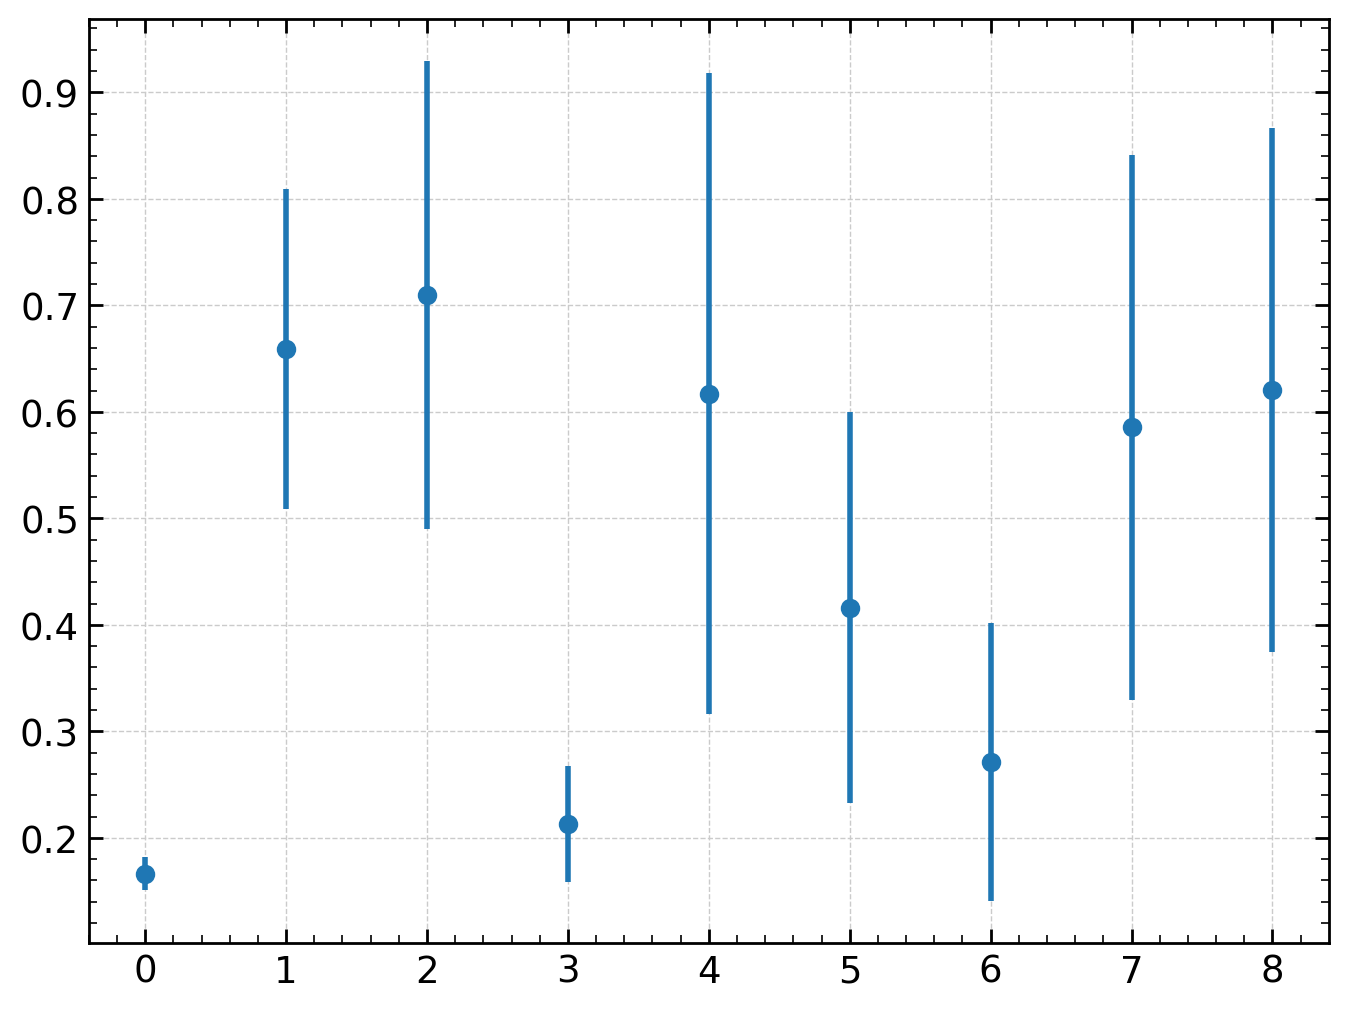

In [37]:
x_ = range(len(percs))
plt.errorbar(x_, mmds[:,1], yerr=mmds[:,1]-mmds[:,0], fmt='o')

In [38]:
percs

,model,N,mmd
0,NLE,1000,"[0.1511550521850586, 0.16640043258666992, 0.22..."
1,NLE,10000,"[0.5086883091926575, 0.6588286757469177, 0.762..."
2,NLE,100000,"[0.489723801612854, 0.709438681602478, 0.79063..."
3,NPE,1000,"[0.15872398853302003, 0.21295899152755737, 0.2..."
4,NPE,10000,"[0.3162719130516052, 0.6170241236686707, 0.699..."
5,NPE,100000,"[0.23224372386932374, 0.41605645418167114, 0.7..."
6,NRE,1000,"[0.1404270839691162, 0.2708541452884674, 0.358..."
7,NRE,10000,"[0.32911829471588133, 0.5853604078292847, 0.75..."
8,NRE,100000,"[0.3749262249469757, 0.6207566261291504, 0.732..."


# Scratch

In [9]:
task = sbibm.get_task("slcp")
prior = task.get_prior()
simulator = task.get_simulator()
observation = task.get_observation(num_observation=5)

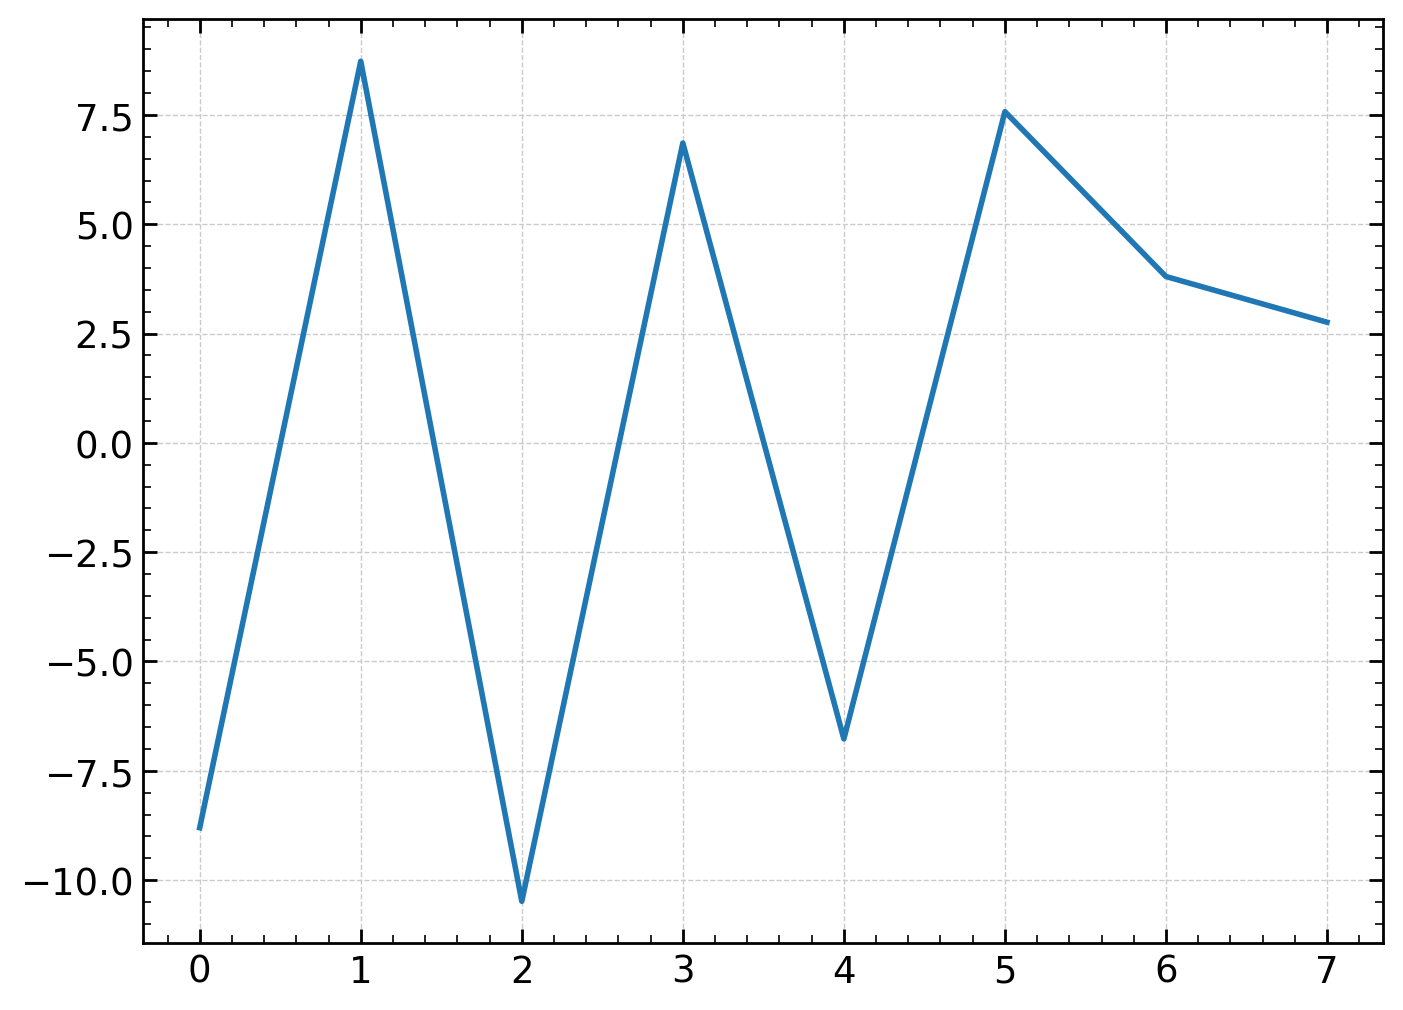

In [10]:
plt.plot(observation[0])

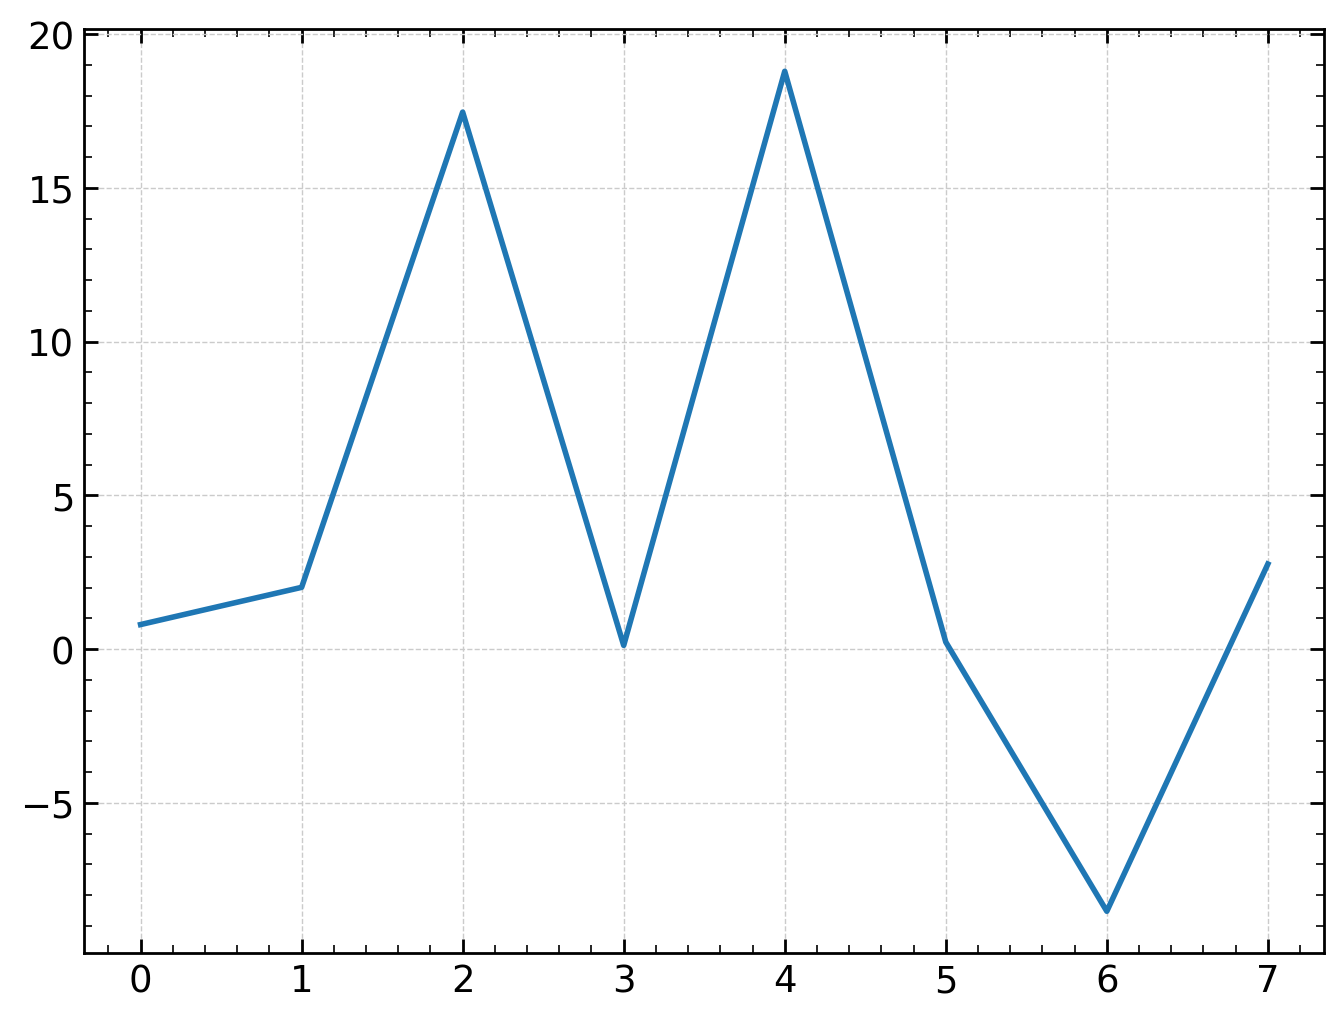

In [18]:
x0 = simulator(torch.tensor([1,2,3,-1,-2]))
plt.plot(x0[0])